<a href="https://colab.research.google.com/github/tomafischer/ai_geeks/blob/main/deeplearning/Intro_to_Deep_Learning_30_minutes_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Deep Learning - a practical approach with Pytorch
**Author**: Tom Fischer 

------
**Description**: 
> Deep learning intro in less than 30 minutes with Pytorch

> We will use an [Artifical Neural Network (ANN)](https://en.wikipedia.org/wiki/Artificial_neural_network) for a regression of Miles Per Gallon (MPG) forcasting based on car features like engine size, horse power, cylinders, etc.

-----------
**Resources:**
- [Pytorch](https://pytorch.org/)
- [Udemy class A deep understanding of deep learning (with Python intro)](https://www.udemy.com/course/deeplearning_x/) 
- [DataCamp - Introduction to Deep Learning with PyTorch](https://www.datacamp.com/courses/introduction-to-deep-learning-with-pytorch)

---------
**Table of Content**
1. Data Prep: Getting data, data normalization, cross-validation, preping for torch
2. Creating Deep Learning Network
3. Train Network
4. Model evaluations => overfitting, epoch analysis
5. Tuning Learning Curves => overfitting, adjusting learning curve, epoch tuning

--------
**Not part of this class:**
6. Regularization: Dropouts, L1/L2 weight regularization, batch training
7. Metaparameter optimazation: activation functions, optimizers, batch normalizations

## 1) Data, Data, Data - From CSV to passing to model
We will use the Seaborn mpg.csv dataset to predict the mpg from car features

**Steps:**
- Loading the data
- Understanding data - descriptive/statistic evaluation
- Defining Features
- Scaling/normalization of data: z-score or min/max scaling
- One hot encoding for categorical data
- Cross validation: splitting data into train/test/devset
- Transform into Tensors for the Neural Network libraries, e.g. for GPU


In [ ]:
# the usual math and data packages
import numpy as np
import pandas as pd
# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
# model evaluation, z-score
import scipy.stats as stats
# data prep
from sklearn.model_selection import train_test_split
# data cross-validation tools
from sklearn import preprocessing
# unit testing
import unittest

In [ ]:
#####
#   Using Seaborn library to import data from CSV
#####
import seaborn as sns
cars_pd= sns.load_dataset('mpg')
#dropping na values
cars_pd = cars_pd.dropna()
print(f"Length for car data: {len(cars_pd)}\n ")
cars_pd.head()
# some plots to shwo the data


Length for car data: 392
 


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


###    Statics on the numerical values
> Usually we would spend more time here, talk to SMEs, 
> look for outliers, have coffee in between... 

In [ ]:
######
#    just some basic stats for the intro 
#####
cars_pd.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000


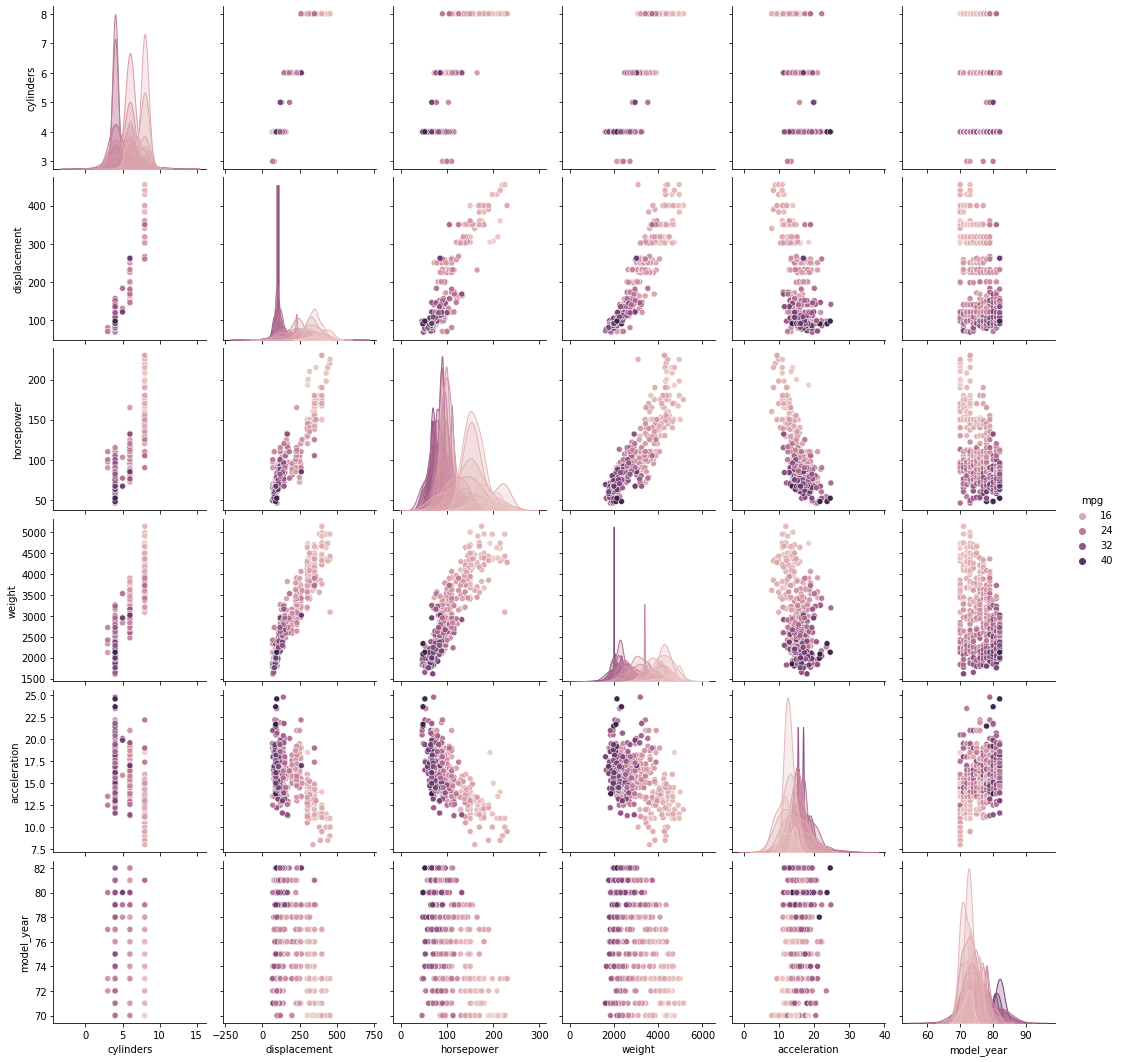

In [ ]:
# Correlation Plots
sns.pairplot(cars_pd, hue='mpg')
plt.show()

### Defining features, 
### Normalization / Scale data
### Data prep for deep learning model 
### Data Cross validation - splitting data

**Question to discuss:** 
- Why is normalization of data so important?
- Why is data prepared for deep learning? 
- Why is Cross validation so important? Discuss Overfitting

In [ ]:
#####
#    Defining features - for the model
#####
feature_labels = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']
pred_label =['mpg']

####
#    Normalize / Scale data
####
# getting numpy array of data
cars_x_np = cars_pd[feature_labels].values
cars_y_np = cars_pd[pred_label].values
# normalize / scale the data
scaler_x = preprocessing.StandardScaler()
scaler_y =  preprocessing.StandardScaler()
cars_x_np = scaler_x.fit_transform(cars_x_np)
cars_y_np = scaler_y.fit_transform(cars_y_np)

#####
#    Create Tensors
#####
cars_x = torch.tensor(cars_x_np).float()
cars_y = torch.tensor(cars_y_np).float()

######
#.    Creating train and test set - Cross validation
######
train_x, test_x, train_y, test_y  = train_test_split(cars_x, cars_y, train_size=0.8)

In [ ]:
print(f"Cars_x.shape:  {cars_x.shape}")
print(f"Cars_y.shape:  {cars_y.shape}")
print("Train data:")
print(f"train_x.shape: {train_x.shape}")
print(f"train_y.shape: {train_y.shape}")
print(f"Test data:")
print(f"test_x.shape:  {test_x.shape}")
print(f"test_y.shape:  {test_y.shape}")

Cars_x.shape:  torch.Size([392, 6])
Cars_y.shape:  torch.Size([392, 1])
Train data:
train_x.shape: torch.Size([313, 6])
train_y.shape: torch.Size([313, 1])
Test data:
test_x.shape:  torch.Size([79, 6])
test_y.shape:  torch.Size([79, 1])


### Finally! The data is ready for deeplearning
Data has to be 
- normalized
- hot one encoded
- transfered into tensors for GPU training

In [ ]:
# first few training records
test_x[0:4,:]

tensor([[ 1.4839,  0.6467,  0.1439,  0.2869, -0.7409, -0.2663],
        [-0.8640, -1.1043, -0.8967, -1.0651,  1.4367, -1.3535],
        [-0.8640, -0.8268, -0.7666, -0.8400, -0.1239,  1.0928],
        [ 0.3100,  0.0535, -0.4284,  0.0972,  0.5657,  1.3646]])

In [ ]:
test_y[0:4,:]

tensor([[-0.4421],
        [ 0.8408],
        [ 1.1230],
        [-0.4164]])

## 2) Creating Deep Learning Model

### Neural Network Layout and Math for one Neuron
<img src="https://github.com/tomafischer/ai_geeks/blob/main/images/neural_network.png?raw=true"
     alt="Neural Networks"
     style="float: left; margin-right: 10px;" width="600" height="270"/>
<img src="https://github.com/tomafischer/ai_geeks/blob/main/images/neural_networks_neuron_overview.jpeg?raw=true"
     alt="Neural Networks"
     style="float: left; margin-right: 10px;" width="600" height="270"/>


### What do we need:
- **Deep Learning Model** (see above)
- **Loss Function**: Mesaure accuracy of model  => Root Square Mean RMS
- **Optimzer**: To handle the optimization for training
- **Forward progagation**: Compute output based on input for predicting a dataset 
- **Backwards propagation** (backprop): Adjust the weights based on loss/cost
- **Learning Rate**: Amount of adjustments during the backprop
- **Epochs**: Amount of iterations for the learning process. Each epoch uses the full dataset with full backprop 

In [ ]:
##########
#         Model definition 
##########

class CarsNeuralNetwork(nn.Module):
  def __init__(self, lr= 0.01):
    super().__init__()

    # Model definition
    self.model =  nn.Sequential(
      nn.Linear(6, 9),      ## input layer
      nn.ReLU(),            #  ReLU activation function
      nn.Linear(9,12),      ## first hidden linear layer
      nn.ReLU(),            #  ReLU activation function
      nn.Linear(12,6),      ## second hidden linear layer
      nn.ReLU(),            #  ReLU activation function
      nn.Linear(6,1)        ## output layer
    )
  
    # learning rate
    self.learning_rate = lr
  
    # loss function
    self.loss_fn = nn.MSELoss() # Mean Square Error

    #optimizer - used for backprop
    self.optimizer = torch.optim.SGD(self.model.parameters(), lr= self.learning_rate)
  
  def forward(self,x):
    """
    Forward progagation: 
    input: records to be passed through the model. 
      Note: the record size must match the model size (in our case 6)
    output: predicted values  
    """
    pred = self.model(x)
    return pred

  def train_model(self, x, y):
    """
    Training method with backprogation
    input: x, y for training
    output: loss from forward pass 
    """
    #forward pass
    pred = self.model(x)

    #compute loss
    loss = self.loss_fn(pred, y)

    #backprop
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    return loss

In [ ]:
# let's look at the model
cars_ann = CarsNeuralNetwork(lr=0.01)
print(f"Model definition:\n{cars_ann.model}")

Model definition:
Sequential(
  (0): Linear(in_features=6, out_features=9, bias=True)
  (1): ReLU()
  (2): Linear(in_features=9, out_features=12, bias=True)
  (3): ReLU()
  (4): Linear(in_features=12, out_features=6, bias=True)
  (5): ReLU()
  (6): Linear(in_features=6, out_features=1, bias=True)
)


In [ ]:
# manual training run to test before we get to the big training loops (one of many....)
pred = cars_ann(train_x)
loss = cars_ann.loss_fn(pred,train_y)
cars_ann.optimizer.zero_grad()
loss.backward()
cars_ann.optimizer.step()

In [ ]:
loss

tensor(1.0853, grad_fn=<MseLossBackward>)

## 3) Train model
- What are epochs?
- What are the biggest impacts: **Epochs** and **Learning rates**

In [ ]:
##############
#              This is the main Training loop. 
#              Note: No batch trainin in this version            
##############
def train_epochs(model, train_x, train_y, test_x, test_y, epochs = 100, verbose = True):
  losses_train = []
  losses_test = []

  for epoch in range(epochs):

    # run the training cycle 
    #   - with backprob
    loss_train = model.train_model(train_x,train_y)
    # append the train loss
    losses_train.append(loss_train.item())

    # evaluate the model on the test data
    # -> run only forward with test data
    with torch.no_grad():
      pred_test = model(test_x)
      loss_test = model.loss_fn(pred_test, test_y)
      # append the test loss
      losses_test.append(loss_test.item())
    
    # intermediate print out
    if verbose and epoch % 20 == 0:
      print(f"Epoch [{epoch+1}/{epochs}] - Loss Train: {loss_train} - Loss Test: {loss_test} ")
  return losses_train, losses_test
 




### Big Training - Better get some coffee or get a GPU

In [ ]:
########
#        The actual training is finally happening!!!!
#        !!!!!!!!!!! This is the part which can take a few days !!!!!!!!!!!
########

cars_ann = CarsNeuralNetwork(lr=0.01)
losses_train, losses_test = train_epochs(model= cars_ann, train_x= train_x, train_y= train_y, 
                      test_x= test_x, test_y= test_y, epochs = 500)

Epoch [1/500] - Loss Train: 1.1000422239303589 - Loss Test: 0.9500710964202881 
Epoch [21/500] - Loss Train: 1.010525107383728 - Loss Test: 0.9457911252975464 
Epoch [41/500] - Loss Train: 0.9634622931480408 - Loss Test: 0.94374680519104 
Epoch [61/500] - Loss Train: 0.9310560822486877 - Loss Test: 0.9340395331382751 
Epoch [81/500] - Loss Train: 0.8960270881652832 - Loss Test: 0.9078109264373779 
Epoch [101/500] - Loss Train: 0.8495993614196777 - Loss Test: 0.8610909581184387 
Epoch [121/500] - Loss Train: 0.7861928939819336 - Loss Test: 0.7889893054962158 
Epoch [141/500] - Loss Train: 0.7029839754104614 - Loss Test: 0.6910894513130188 
Epoch [161/500] - Loss Train: 0.6064189672470093 - Loss Test: 0.5792121291160583 
Epoch [181/500] - Loss Train: 0.512028694152832 - Loss Test: 0.475535124540329 
Epoch [201/500] - Loss Train: 0.43053603172302246 - Loss Test: 0.39390799403190613 
Epoch [221/500] - Loss Train: 0.3651025891304016 - Loss Test: 0.33423319458961487 
Epoch [241/500] - Loss T

## 4) Evaluate Model - basis for Model tuning
based on Learning rate 

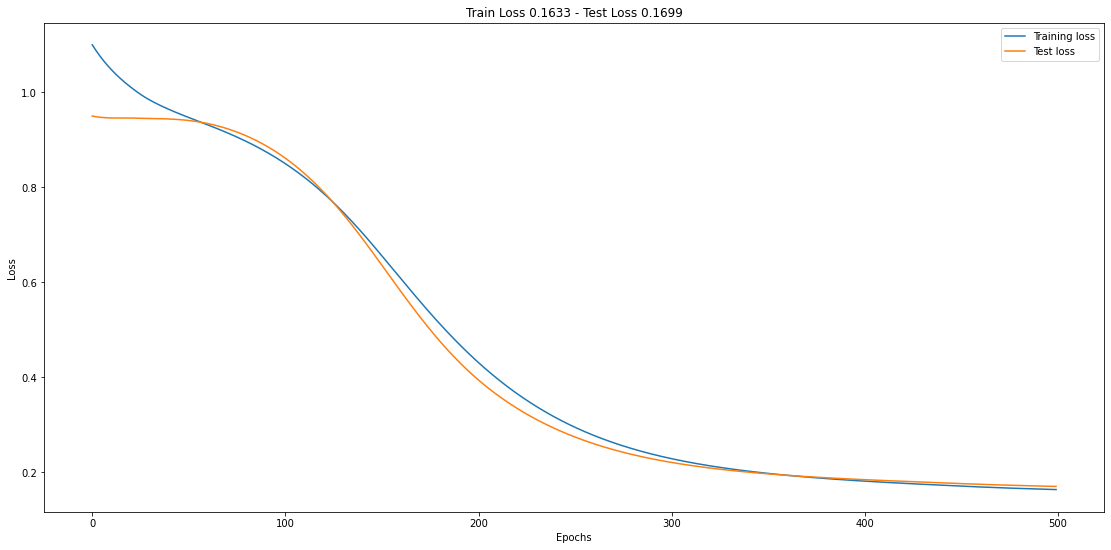

In [ ]:
######
#      Plot Losses
#      for Classifications we would add accuracy and the Confusion Matrix
######
fig, axs = plt.subplots(1,1, figsize =(19,9))
ax = axs
ax.plot(losses_train, label="Training loss")
ax.plot()
ax.plot(losses_test, label= "Test loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title(f"Train Loss {losses_train[-1]:.4f} - Test Loss {losses_test[-1]:.4f}")
ax.legend()
plt.show()

## 5) Investigating/Tuning Learning rate
We look at the effects of the learning rate and compare the learning rate curves 

**Question to think about:**
- How does it affect overfitting? What curves shapes would indicate that?
- What does a wiggle at the end of the learning curve mean?


In [ ]:
# Meta experiment
# creating learning rates
learning_rates = np.linspace(0.001,0.1, 15)
#print(f"Learning rates: {learning_rates}")

losses_train_all =[]
losses_test_all =[]
for lr in learning_rates:
  #print(f"lr: {lr}")
  cars_ann = CarsNeuralNetwork(lr=lr)
  losses_train, losses_test = train_epochs(model= cars_ann, train_x= train_x, train_y= train_y, 
                      test_x= test_x, test_y= test_y, epochs = 2000, verbose= False)
  losses_train_all.append(losses_train)
  losses_test_all.append(losses_test) 
  print(f"Learning rate {lr:.4f} - loss training {losses_train[-1]} - loss testing {losses_test[-1]}")



Learning rate 0.0010 - loss training 0.570827305316925 - loss testing 0.7241930365562439
Learning rate 0.0081 - loss training 0.12021046876907349 - loss testing 0.13049395382404327
Learning rate 0.0151 - loss training 0.10951867699623108 - loss testing 0.12956419587135315
Learning rate 0.0222 - loss training 0.10619695484638214 - loss testing 0.13120463490486145
Learning rate 0.0293 - loss training 0.10089734196662903 - loss testing 0.13506773114204407
Learning rate 0.0364 - loss training 0.10590960085391998 - loss testing 0.12437509000301361
Learning rate 0.0434 - loss training 0.10462284088134766 - loss testing 0.14084629714488983
Learning rate 0.0505 - loss training 0.0995461717247963 - loss testing 0.14820709824562073
Learning rate 0.0576 - loss training 0.08614328503608704 - loss testing 0.11502828449010849
Learning rate 0.0646 - loss training 0.10456617921590805 - loss testing 0.1279783993959427
Learning rate 0.0717 - loss training 0.09677714854478836 - loss testing 0.13340269029

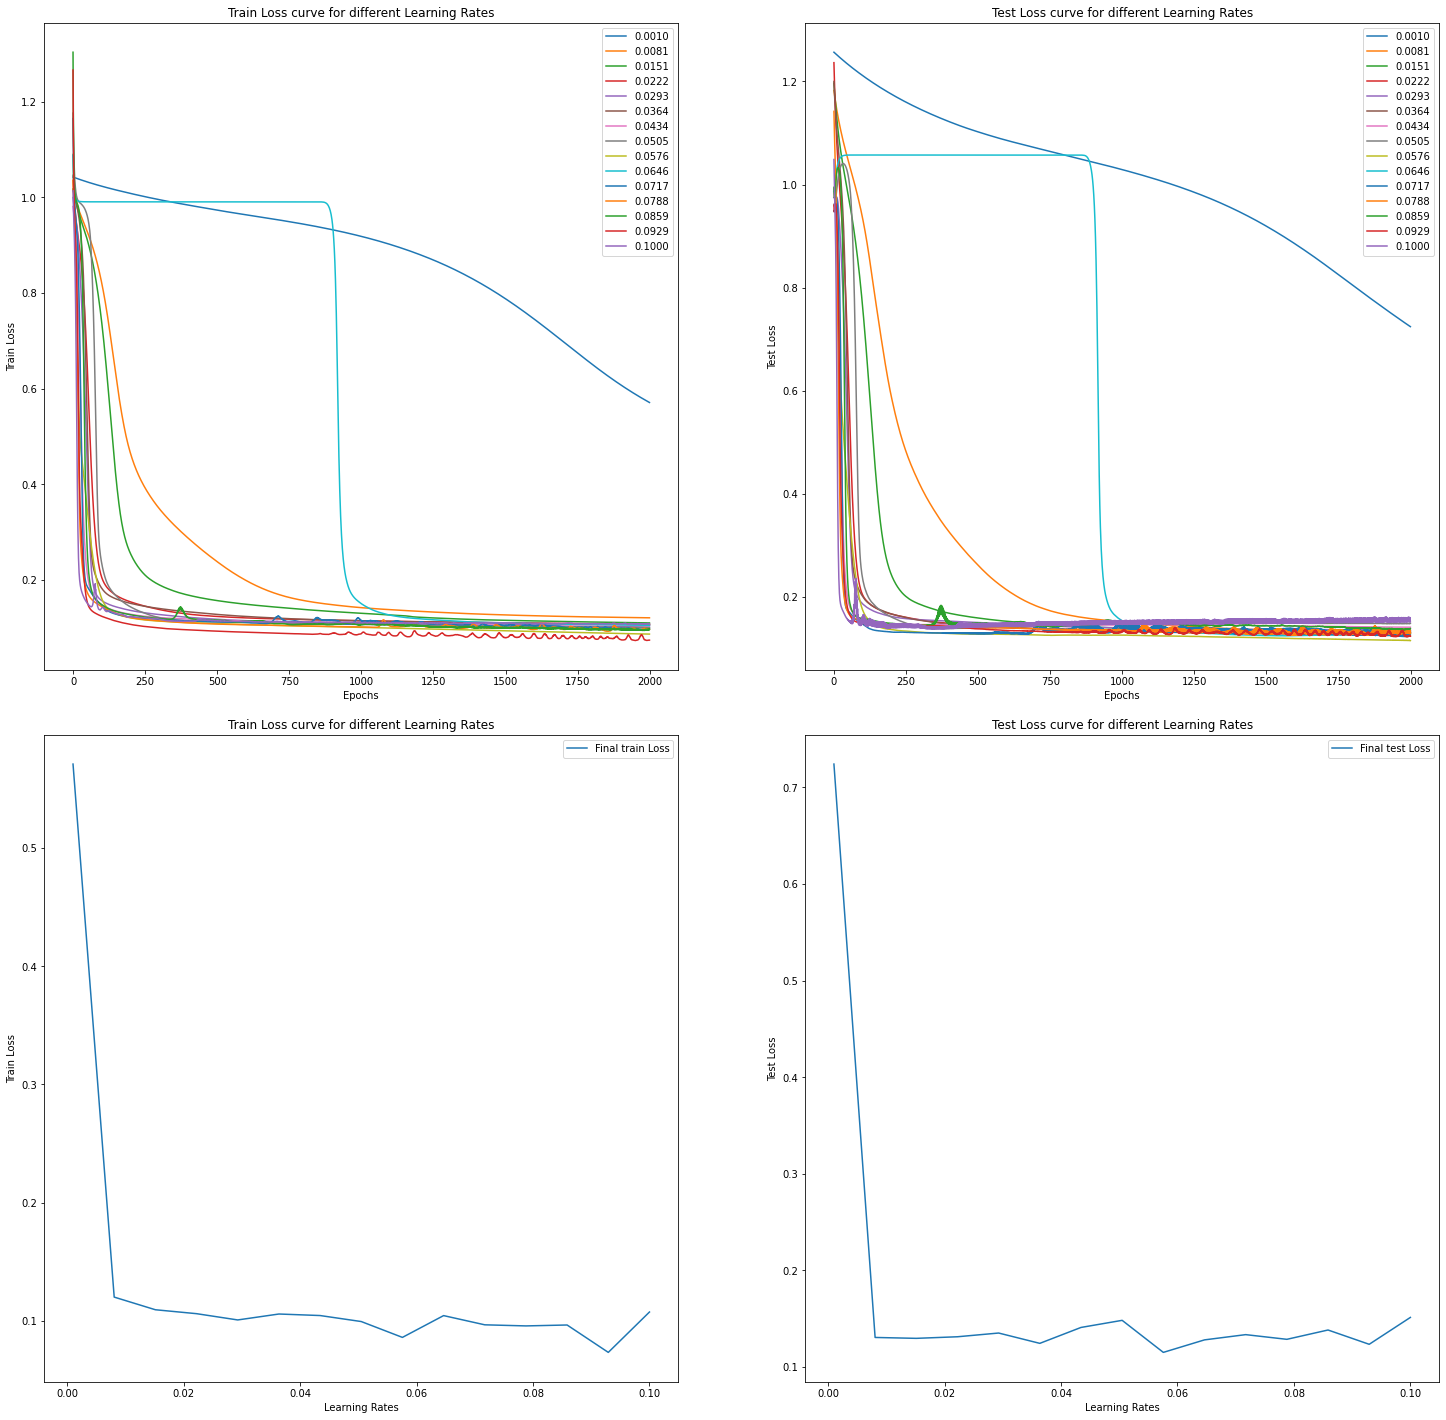

In [ ]:
# charting
fig, (ax1, ax2) = plt.subplots(2,2, figsize=(25,25))
# plotting learning curves
ax = ax1[0]
for lr, curve in zip(learning_rates,losses_train_all ):
  ax.plot(curve, label=f"{lr:.4f}")
ax.legend()
ax.set_xlabel("Epochs")
ax.set_ylabel("Train Loss")
ax.set_title("Train Loss curve for different Learning Rates")

ax = ax1[1]
for lr, curve in zip(learning_rates,losses_test_all ):
  ax.plot(curve, label=f"{lr:.4f}")
ax.legend()
ax.set_xlabel("Epochs")
ax.set_ylabel("Test Loss")
ax.set_title("Test Loss curve for different Learning Rates")

# plotting final Losses
ax = ax2[0]
losses_train_all_final = np.array(losses_train_all)[:,-1]
ax.plot(learning_rates, losses_train_all_final, label = "Final train Loss")
ax.legend()
ax.set_xlabel("Learning Rates")
ax.set_ylabel("Train Loss")
ax.set_title("Train Loss curve for different Learning Rates")



ax = ax2[1]
losses_test_all_final = np.array(losses_test_all)[:,-1]
ax.plot(learning_rates, losses_test_all_final, label = "Final test Loss")
ax.legend()
ax.set_xlabel("Learning Rates")
ax.set_ylabel("Test Loss")
ax.set_title("Test Loss curve for different Learning Rates")


plt.subplots_adjust(hspace=0.1)
plt.show()